# Laboratorium

### Konfiguracja

In [83]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [84]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Rozwiązanie

In [85]:
from random import *
from math import *
from numpy import *
import functools
import time

In [86]:
#verts punktów o współrzędnych z przedziału (-x, x)*(-y, y)
def genSetA(verts, x1 = -100, x2 = 100, y1 = -100, y2 = 100):
    seed(1000)
    setA = []
    for i in range(verts):
        setA.append([uniform(x1, x2), uniform(y1, y2)])
    return setA

In [87]:
# verts punktów leżących na okręgu o promieniu r i środku (x,y)
def genSetB(verts, r = 10, x = 0, y = 0):
    seed(1000)
    setB = []
    for i in range(verts):
        a = uniform(0,1) * 2 * pi
        setB.append([sin(a) * r + x, cos(a) * r + y])
    return setB

In [88]:
# verts punktów leżących na bokach prostokąta (-x,y), (-x,-y), (x,y), x,-y)
def genSetC(verts, x1 = -10, y1 = 10, x2 = -10, y2 = -10, x3 = 10, y3 = -10, x4 = 10, y4 = 10):
    seed(1000)
    setC = []
    for i in range(verts):
        a = randint(1, 4)
        if a == 1:
            setC.append([x1, uniform(y1, y2)])
        if a == 2:
            setC.append([x3, uniform(y3, y4)])
        if a == 3:
            setC.append([uniform(x1, x3), y1])
        if a == 4:
            setC.append([uniform(x2, x4), y3])
    return setC

In [89]:
# vertsA punktow na osiach, vertsB na przekatnych, wierzcholki(xi, y1)
def genSetD(vertsA, vertsB = 0, x1 = 0, y1 = 0, x2 = 10, y2 = 0, x3 = 10, y3 = 10, x4 = 0, y4 = 10):
    if vertsB == 0:
        vertsB = vertsA//2
    seed(1000)
    setD = []
    setD.append([x1, y1])
    setD.append([x2, y2])
    setD.append([x3, y3])
    setD.append([x4, y4])
    for i in range(vertsA):
        setD.append([x1, uniform(y1, y4)])
        setD.append([uniform(x1, x2), y1])
    for i in range(vertsB):
        x = uniform(x1, x2)
        setD.append([x, x])
        setD.append([x, (y4)-x])
    return setD

<IPython.core.display.Javascript object>


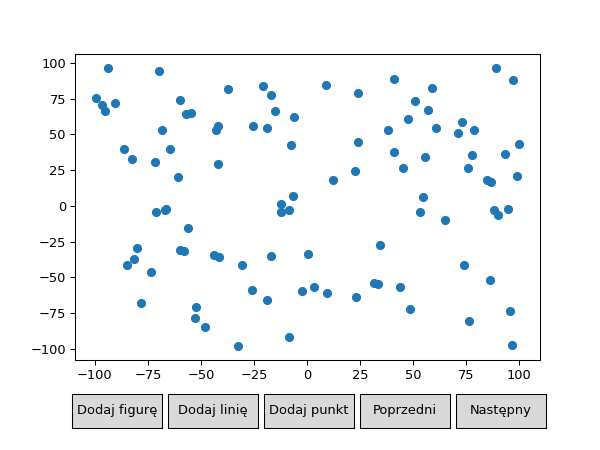

In [90]:
# Generowanie zbioru a
%matplotlib notebook
setA = genSetA(100, -100, 100, -100, 100)
plot = Plot(points = [PointsCollection(setA)])
plot.draw()

<IPython.core.display.Javascript object>


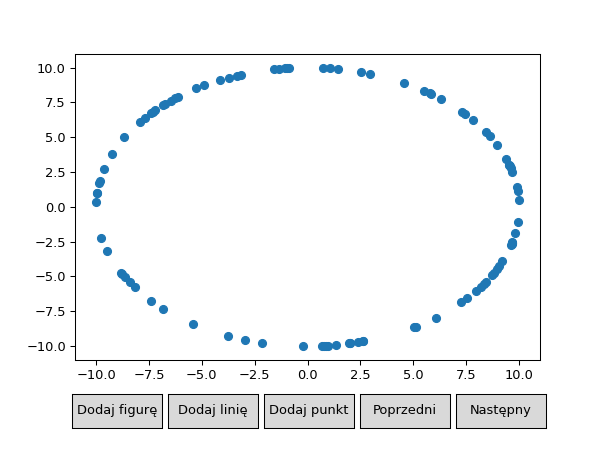

In [91]:
# Generowanie zbioru b
%matplotlib notebook
setB = genSetB(100, 10, 0, 0)
plot = Plot(points = [PointsCollection(setB)])
plot.draw()

<IPython.core.display.Javascript object>


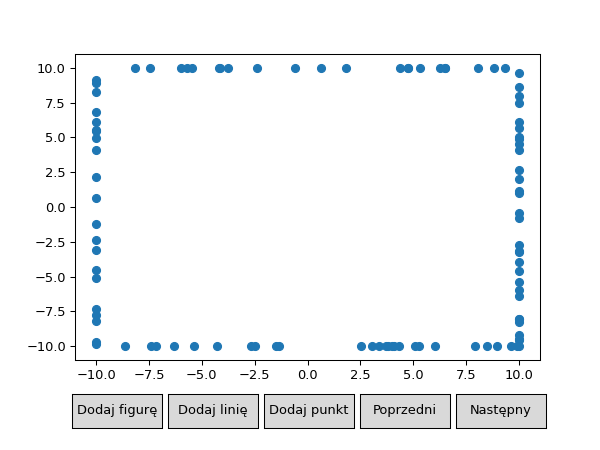

In [92]:
# Generowanie zbioru c
%matplotlib notebook
setC = genSetC(100, -10, 10, -10, -10, 10, -10, 10, 10)
plot = Plot(points = [PointsCollection(setC)])
plot.draw()

<IPython.core.display.Javascript object>


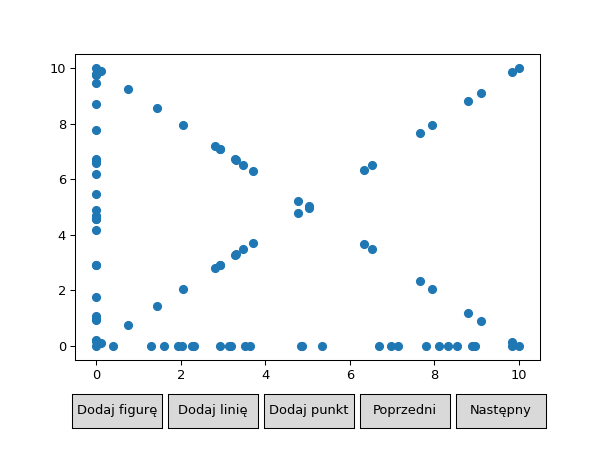

In [93]:
# Generowanie zbioru d
%matplotlib notebook
setD = genSetD(25, 20, 0, 0, 10, 0, 10, 10, 0, 10)
plot = Plot(points = [PointsCollection(setD)])
plot.draw()

In [94]:
def printToFile(points): # Save verticles to file
    
    name = input("Wprowadz nazwe pliku: ")
    file = open(name+".txt","w") 
    
    for i in points: 
        file.write(str(i[0]) + ' - ' + str(i[1])+'\n') 
 
    file.close()

In [95]:
def compareTime(setT): # Compare time of Graham and Jarvis algorithms on the same points
    start1 = time.time()
    grahamToTest(setT)
    a = time.time() - start1
    print("Graham: ", a)
    
    start2 = time.time()
    jarvisToTest(setT)
    b = time.time() - start2
    print("Jarvis: ", b)
    return [a, b]

In [96]:
def lowestXY(a, b): # find point with the lowest Y and X
    if a[1] < b[1]:
        return a
    if a[1] > b[1]:
        return b
    if a[0] < b[0]:
        return a
    return b

In [97]:
def dist(a,b): # Count dist between two points
        return (a[0]-b[0])**2 + (a[1]-b[1])**2
    
def det(a, b, c, e = 10 ** -10): # if point is on left/right/equal
        det = a[0]*b[1]+a[1]*c[0]+b[0]*c[1]-c[0]*b[1]-a[1]*b[0]-a[0]*c[1]
        if det > e:
            return 1
        if det < -e:
            return -1
        else:
            return 0  

# Graham and Jarvis

In [98]:
def compareAngle(a, b, c, e = 10**-10): # to angleSort in GrahamAlgorithm
    if a == b :
        return -1
    if a == c:
        return 1
    det1 = det(a, b, c, e)
    det2 = det(a, c, b, e)
    if det1 == det2:
        if dist(a, b) > dist(a, c):
            return -1
        else:
            return 1
    if det1 > 0:
        return -1
    return 1   
def graham(setT, writeFile = False):
    copySet = setT.copy()
    scenes = []
    scenes.append(Scene([PointsCollection(copySet, color = 'blue')]))
                    
    P = functools.reduce(lambda a, b: lowestXY(a, b), copySet)
                    
    tab = sorted(copySet, key=functools.cmp_to_key(lambda a, b: compareAngle(P, a, b)))
    
    datasetDelEquals = [tab[0], tab[1]]
    for i in range(2, len(tab)):
        det1 = det(P, tab[i], tab[i-1])
        det2 = det(P, tab[i-1], tab[i])
        if det1 != det2:
            datasetDelEquals.append(tab[i])
    datasetDelEquals.append(P)
    scenes.append(Scene([PointsCollection(datasetDelEquals, color = "blue"), PointsCollection([tab[0], tab[1]], color = "red"), PointsCollection([datasetDelEquals[2]], color = "red")], [LinesCollection([[tab[0],tab[1]]], color = "black"), LinesCollection([[tab[1], datasetDelEquals[2]]], color = "green")]))
    
    Stc = [datasetDelEquals[0], datasetDelEquals[1], datasetDelEquals[2]]
    i = 3
    t = len(Stc) - 1
    while i < len(datasetDelEquals):
        scenes.append(Scene([PointsCollection(datasetDelEquals, color = "blue"), PointsCollection(Stc[0:t+1], color = "red"), PointsCollection([datasetDelEquals[i]], color = "red")], [LinesCollection([[Stc[p], Stc[p-1]] for p in range(1, t+1)], color = "black" ), LinesCollection([[Stc[t], datasetDelEquals[i]]], color = "green")]))
        if det(Stc[t-1], Stc[t], datasetDelEquals[i]) > 0:
            Stc.append(datasetDelEquals[i])
            t += 1
            i += 1
        else:
            if t >= 2:
                Stc.pop()
                t -= 1  
    scenes.append(Scene([PointsCollection(copySet, color = "blue"), PointsCollection(Stc.copy(), color = "red")], [LinesCollection([[Stc[p], Stc[p-1]] for p in range(1, len(Stc))], color = "black" )]))
    if writeFile:
        printToFile(Stc)
    return scenes

In [104]:
def compareAnglevJarvis(a, b, c, e = 10**-10): # to angleSort in GrahamAlgorithm
    det1 = det(a, b, c, e)
    det2 = det(a, c, b, e)
    if det1 == det2:
        if dist(a, b) > dist(a, c):
            return b
        else:
            return c
    if det1 > 0:
        return b
    return c
def jarvis(setT, writeFile = False):
    copySet = setT.copy()
    scenes = []
    
    scenes.append(Scene([PointsCollection(copySet.copy(), color = 'blue')]))               
    PointStart = functools.reduce(lambda a, b: lowestXY(a, b), copySet)
    Point = PointStart
    Stack = []
    Stack.append(PointStart)
    scenes.append(Scene([PointsCollection(copySet.copy(), color = 'blue'), PointsCollection([Stack[0]], color = "red")]))
    while len(Stack) < 2 or Point != PointStart:
        PointNext = functools.reduce(lambda a, b: compareAnglevJarvis(Point, a, b), copySet)
        copySet.remove(PointNext)
        Point = PointNext
        Stack.append(PointNext)
        scenes.append(Scene([PointsCollection(copySet.copy(), color = 'blue'), PointsCollection(Stack.copy(), color = "red")], [LinesCollection([[Stack[p], Stack[p-1]] for p in range(1, len(Stack)-1)], color = "black"), LinesCollection([[Stack[len(Stack)-1], Stack[len(Stack)-2]]], color = "green")]))
    scenes.append(Scene([PointsCollection(copySet.copy(), color = 'blue'), PointsCollection(Stack.copy(), color = "red")], [LinesCollection([[Stack[p], Stack[p-1]] for p in range(1, len(Stack))], color = "black")]))
    if writeFile:
        printToFile(Stack)
    return scenes

# Function without generating scenes(to Test):

In [105]:
def grahamToTest(setT, writeFile = False):
    copySet = setT.copy()
                    
    P = functools.reduce(lambda a, b: lowestXY(a, b), copySet)
                    
    tab = sorted(copySet, key=functools.cmp_to_key(lambda a, b: compareAngle(P, a, b)))
    
    datasetDelEquals = [tab[0], tab[1]]
    for i in range(2, len(tab)):
        det1 = det(P, tab[i], tab[i-1])
        det2 = det(P, tab[i-1], tab[i])
        if det1 != det2:
            datasetDelEquals.append(tab[i])
    datasetDelEquals.append(P)
    
    Stc = [datasetDelEquals[0], datasetDelEquals[1], datasetDelEquals[2]]
    i = 3
    t = len(Stc) - 1
    while i < len(datasetDelEquals):
        if det(Stc[t-1], Stc[t], datasetDelEquals[i]) > 0:
            Stc.append(datasetDelEquals[i])
            t += 1
            i += 1
        else:
            if t >= 2:
                Stc.pop()
                t -= 1  
    

In [107]:
def jarvisToTest(setT, writeFile = False):
    copySet = setT.copy()
               
    PointStart = functools.reduce(lambda a, b: lowestXY(a, b), copySet)
    Point = PointStart
    Stack = []
    Stack.append(PointStart)
    while len(Stack) < 2 or Point != PointStart:
        PointNext = functools.reduce(lambda a, b: compareAnglevJarvis(Point, a, b), copySet)
        copySet.remove(PointNext)
        Point = PointNext
        Stack.append(PointNext)
jarvisToTest(setB)

# Results

<IPython.core.display.Javascript object>


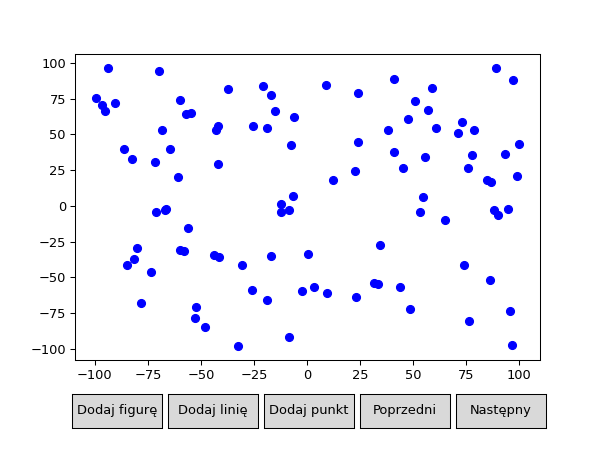

In [108]:
scenes = graham(setA)
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


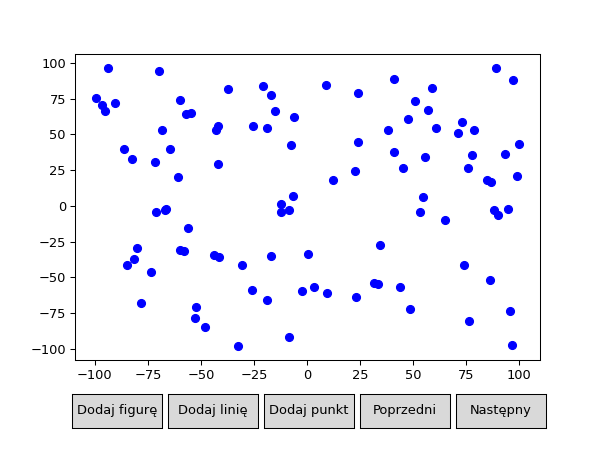

In [110]:
scenes = jarvis(setA)
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


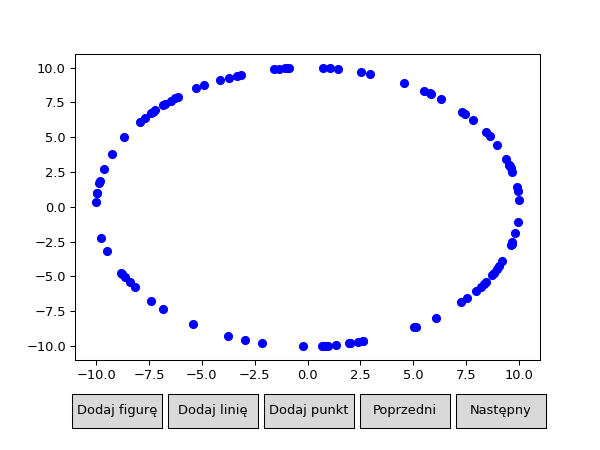

In [111]:
scenes = graham(setB)
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


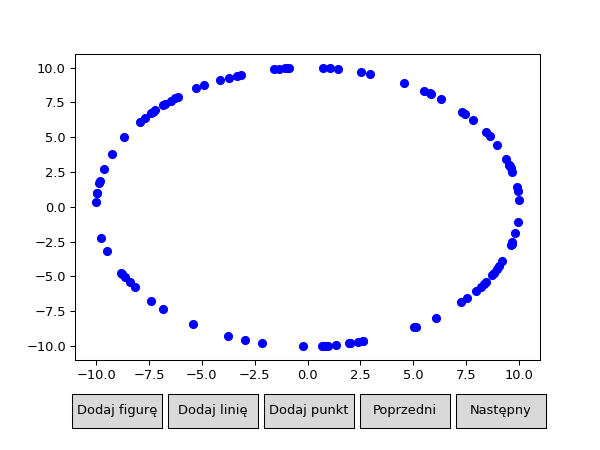

In [112]:
scenes = jarvis(setB)
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


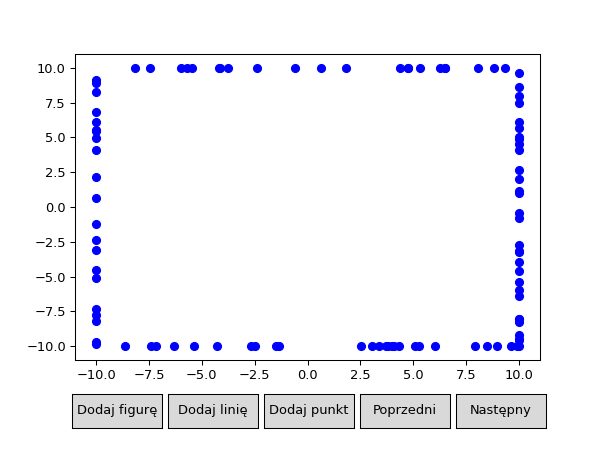

In [114]:
scenes = graham(setC)
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


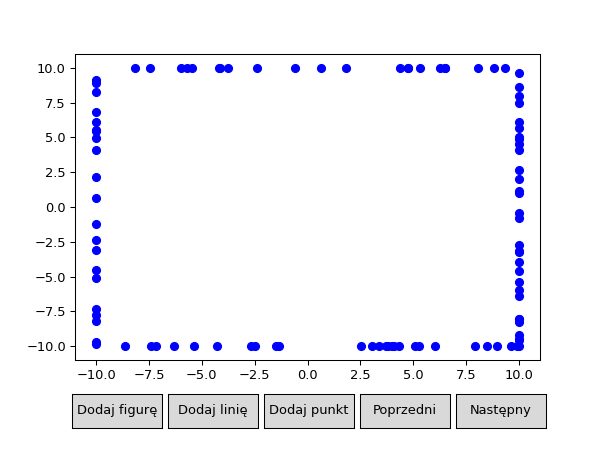

In [116]:
scenes = jarvis(setC)
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


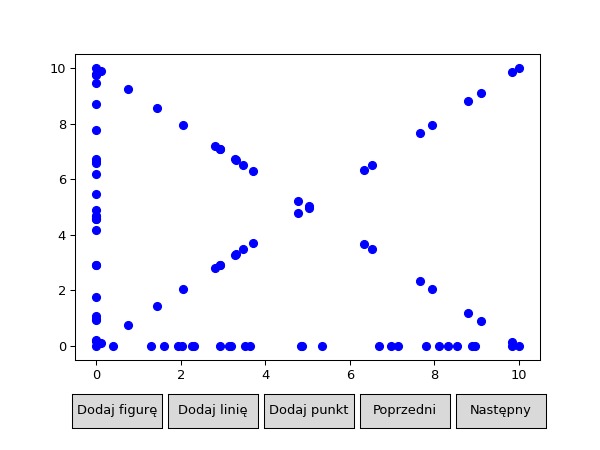

In [117]:
scenes = graham(setD)
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


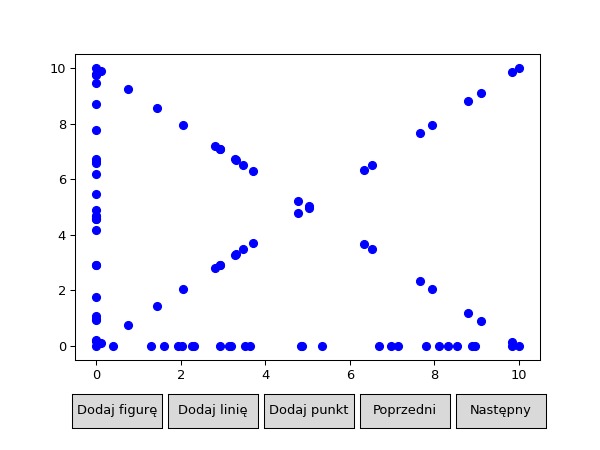

In [119]:
scenes = jarvis(setD)
plot = Plot(scenes)
plot.draw()

# Time testing

In [120]:
# Test Graham and Jarvis functions for different sets of points
file = open("wynikiA"+".txt","w") # Results will be saved on file
A = [i for i in range(250, 4250, 250)]
for points in A:
    setT = genSetA(points)
    score = compareTime(setT)
    file.write(str(points) + ' ' + str(score[0]) + ' ' + str(score[1]) + '\n')
file.close()

Graham:  0.004003763198852539
Jarvis:  0.006994962692260742
Graham:  0.007973909378051758
Jarvis:  0.013041257858276367
Graham:  0.012002944946289062
Jarvis:  0.017998218536376953
Graham:  0.01599860191345215
Jarvis:  0.024000167846679688
Graham:  0.021001338958740234
Jarvis:  0.03399395942687988
Graham:  0.026001930236816406
Jarvis:  0.03399968147277832
Graham:  0.03200483322143555
Jarvis:  0.04900550842285156
Graham:  0.035042762756347656
Jarvis:  0.043993234634399414
Graham:  0.0410001277923584
Jarvis:  0.04600071907043457
Graham:  0.04900622367858887
Jarvis:  0.054000139236450195
Graham:  0.039513587951660156
Jarvis:  0.062497615814208984
Graham:  0.0625002384185791
Jarvis:  0.06954550743103027
Graham:  0.05441451072692871
Jarvis:  0.08440732955932617
Graham:  0.07241153717041016
Jarvis:  0.07600617408752441
Graham:  0.07599925994873047
Jarvis:  0.08345341682434082
Graham:  0.08106017112731934
Jarvis:  0.08096027374267578


In [122]:
# Test Graham and Jarvis functions for different sets of points
file = open("wynikiB"+".txt","w") # Results will be saved on file
B = [i for i in range(100, 410, 10)]
for points in B:
    setT = genSetB(points)
    score = compareTime(setT)
    file.write(str(points) + ' ' + str(score[0]) + ' ' + str(score[1]) + '\n')
file.close()

Graham:  0.0019941329956054688
Jarvis:  0.023042917251586914
Graham:  0.0030379295349121094
Jarvis:  0.02599811553955078
Graham:  0.0030002593994140625
Jarvis:  0.029004335403442383
Graham:  0.0030455589294433594
Jarvis:  0.03297090530395508
Graham:  0.004024982452392578
Jarvis:  0.03901362419128418
Graham:  0.004051923751831055
Jarvis:  0.04500150680541992
Graham:  0.004996299743652344
Jarvis:  0.05402874946594238
Graham:  0.0049991607666015625
Jarvis:  0.060005903244018555
Graham:  0.0060465335845947266
Jarvis:  0.06399965286254883
Graham:  0.0060231685638427734
Jarvis:  0.07397222518920898
Graham:  0.0069696903228759766
Jarvis:  0.08104228973388672
Graham:  0.00700068473815918
Jarvis:  0.08600044250488281
Graham:  0.007958173751831055
Jarvis:  0.10105395317077637
Graham:  0.007001638412475586
Jarvis:  0.1029975414276123
Graham:  0.007954835891723633
Jarvis:  0.12104940414428711
Graham:  0.008002042770385742
Jarvis:  0.12099671363830566
Graham:  0.00900578498840332
Jarvis:  0.1359453

In [123]:
# Test Graham and Jarvis functions for different sets of points
file = open("wynikiC"+".txt","w") # Results will be saved on file
C = [i for i in range(100, 3600, 100)]
for points in C:
    setT = genSetC(points)
    score = compareTime(setT)
    file.write(str(points) + ' ' + str(score[0]) + ' ' + str(score[1]) + '\n')
file.close()

Graham:  0.0
Jarvis:  0.0
Graham:  0.0
Jarvis:  0.018772602081298828
Graham:  0.0049707889556884766
Jarvis:  0.004013776779174805
Graham:  0.008999347686767578
Jarvis:  0.007000446319580078
Graham:  0.008999347686767578
Jarvis:  0.0070002079010009766
Graham:  0.011036396026611328
Jarvis:  0.009962081909179688
Graham:  0.0
Jarvis:  0.01562976837158203
Graham:  0.015625715255737305
Jarvis:  0.019068479537963867
Graham:  0.017998218536376953
Jarvis:  0.013000249862670898
Graham:  0.02099919319152832
Jarvis:  0.013999462127685547
Graham:  0.0240020751953125
Jarvis:  0.016997575759887695
Graham:  0.024997234344482422
Jarvis:  0.018002033233642578
Graham:  0.02899646759033203
Jarvis:  0.019998788833618164
Graham:  0.03300309181213379
Jarvis:  0.022996902465820312
Graham:  0.03499960899353027
Jarvis:  0.02700042724609375
Graham:  0.03699922561645508
Jarvis:  0.025000810623168945
Graham:  0.037999629974365234
Jarvis:  0.02599930763244629
Graham:  0.039999961853027344
Jarvis:  0.026998996734619

In [124]:
# Test Graham and Jarvis functions for different sets of points
file = open("wynikiD"+".txt","w") # Results will be saved on file
D = [i for i in range(100, 3000, 100)]
for points in D:
    setT = genSetD(points)
    score = compareTime(setT)
    file.write(str(points) + ' ' + str(score[0]) + ' ' + str(score[1]) + '\n')
file.close()

Graham:  0.005997657775878906
Jarvis:  0.0029997825622558594
Graham:  0.014014005661010742
Jarvis:  0.004986763000488281
Graham:  0.02200174331665039
Jarvis:  0.008000373840332031
Graham:  0.03100109100341797
Jarvis:  0.009998321533203125
Graham:  0.0390012264251709
Jarvis:  0.010999202728271484
Graham:  0.049001455307006836
Jarvis:  0.02099895477294922
Graham:  0.06899285316467285
Jarvis:  0.023999452590942383
Graham:  0.07200193405151367
Jarvis:  0.020000219345092773
Graham:  0.07999920845031738
Jarvis:  0.020999431610107422
Graham:  0.08499670028686523
Jarvis:  0.022001266479492188
Graham:  0.09499764442443848
Jarvis:  0.02800130844116211
Graham:  0.14200615882873535
Jarvis:  0.07499980926513672
Graham:  0.2799983024597168
Jarvis:  0.07299923896789551
Graham:  0.32799339294433594
Jarvis:  0.08101224899291992
Graham:  0.33998751640319824
Jarvis:  0.08799147605895996
Graham:  0.3662738800048828
Jarvis:  0.0939791202545166
Graham:  0.379241943359375
Jarvis:  0.10099911689758301
Graham: